dataset
https://www.kaggle.com/kmader/mias-mammography

https://medium.com/analytics-vidhya/using-convolutional-neural-networks-for-mammogram-classification-6e67ed4e0cad
https://github.com/cpoles/data_science/blob/main/projects/deep_learning/mias_mammography/notebooks/mias_mammography.ipynb

MIAS Dataset

El conjunto de datos originalmente tiene 332 imágenes de mamografías en escala de grises con un tamaño de 1024x1024. Hay 6 categorías de anomalías clasificadas por gravedad como benignas (B) o malignas (M). A los escaneos normales, es decir, aquellos que no presentaban anomalías, se les dio arbitrariamente el valor (A) con fines de clasificación.


In [48]:
# system related
import os
import sys

# import custom modules
import src.helpers as hp
import src.mammoscan as ms
# path manipulation
from pathlib import Path
# regex
import re
# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image manipulation
from PIL import Image
from IPython.display import Image
# metrics
from sklearn.metrics import confusion_matrix, classification_report
# keras
import tensorflow.keras as ks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#### DataFrame para the Scans Info

La función create_mias_dataset(path:) crea el marco de datos necesario para el experimento. Toma una ruta al archivo de texto ('scan_file_data.txt') que contiene los datos escaneados como argumento.

In [49]:
mias = hp.create_mias_dataset('data_mammo/Info.txt')
mias

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,A,NaN,NaN,NaN
mdb319,D,NORM,A,NaN,NaN,NaN
mdb320,D,NORM,A,NaN,NaN,NaN


#### Descripción del dataframe

#### Mammoscan Class
Mammoscan Class encapsula una imagen escaneada con sus datos correspondientes. La clase proporciona una API para acceder a sus atributos y métodos para trazar y generar imágenes recortadas reducidas para el modelo. La clase Mammoscan se puede utilizar importando el archivo '/scr/modules/mammoscan.py'.

#### Preparación de los datos

Algunos escaneos contienen datos inutilizables y, por lo tanto, deben eliminarse inicialmente ya que carecen de la ubicación de la anomalía. En el módulo helpers.py, hay una función para eliminar dichos escaneos:

Según Gregory et al¹, la instalación de una CNN con imágenes de tamaño pequeño mejoraría el rendimiento computacional y la tasa de recuperación por anomalía. Además, la creación de subconjuntos de las imágenes originales también mejoraría los resultados de la clasificación. Este proceso se denomina aumento de datos, cuyo objetivo es aprovechar el rendimiento de la CNN en el caso de tener una muestra de escaneos tan pequeña como la que proporciona originalmente el conjunto de datos.

La estrategia es crear versiones reducidas rotadas y reflejadas de las anomalías en los escaneos. Estas mamografías contienen coordenadas (x, y) y los radios de las anomalías, lo que indica dónde podría estar el tumor potencial, ya sea benigno (B) o maligno (M). En cuanto a los escaneos normales, se optó por seleccionar aleatoriamente un punto alrededor del centro de la imagen y hacer un recorte de 48x48, como sugieren Gregory et al¹.

[1] Gregory et al, Mammogram Classification using Convolutional Neural Networks

#### Transformación de Imagenes

![](Images/img.png)
original scan

![](Images/img_1.png)
muestra de versiones rotadas recortadas (espejo superior-inferior)

El módulo auxiliar tiene una función llamada generar_submuestras(ruta:, df:) que realiza todas las transformaciones de imagen necesarias y las guarda en la carpeta de submuestras. También genera un marco de datos con datos sobre los escaneos, incluida una versión matricial de la imagen, así como la ubicación de la imagen en la carpeta de submuestras.


In [50]:
mias = hp.generate_subsamples('data_mammo/all-mias/', mias)

D:\Master IA Atrium\TFM\Projects\Practica_Cancer_Classification\src\helpers.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
D:\Master IA Atrium\TFM\Projects\Practica_Cancer_Classification\src\helpers.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
D:\Master IA Atrium\TFM\Projects\Practica_Cancer_Classification\src\helpers.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
D:\Master IA Atrium\TFM\Projects\Practica_Cancer_Classification\src\helpers.py:109: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [51]:
mias

,ab_class,bg,severity,subsample_path,p_matrix
mdb001_0_rotated,CIRC,G,B,../subsamples\mdb001_0_rotated.png,"[[1, 4, 6, 9, 12, 15, 18, 24, 29, 35, 41, 48, ..."
mdb001_0_mirr_lr,CIRC,G,B,../subsamples\mdb001_0_mirr_lr.png,"[[121, 105, 113, 127, 136, 141, 139, 141, 142,..."
mdb001_0_mirr_tp,CIRC,G,B,../subsamples\mdb001_0_mirr_tp.png,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 6, 7, 8, 10, 1..."
mdb001_90_rotated,CIRC,G,B,../subsamples\mdb001_90_rotated.png,"[[121, 110, 96, 98, 98, 99, 107, 130, 139, 127..."
mdb001_90_mirr_lr,CIRC,G,B,../subsamples\mdb001_90_mirr_lr.png,"[[62, 74, 77, 74, 75, 90, 109, 115, 125, 116, ..."
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,A,../subsamples\mdb322_180_mirr_lr.png,"[[210, 210, 205, 203, 204, 207, 209, 210, 208,..."
mdb322_180_mirr_tp,NORM,D,A,../subsamples\mdb322_180_mirr_tp.png,"[[202, 203, 205, 205, 206, 207, 206, 206, 207,..."
mdb322_270_rotated,NORM,D,A,../subsamples\mdb322_270_rotated.png,"[[210, 206, 201, 195, 195, 198, 199, 197, 196,..."
mdb322_270_mirr_lr,NORM,D,A,../subsamples\mdb322_270_mirr_lr.png,"[[178, 177, 179, 182, 183, 184, 186, 184, 182,..."


#### Distribución de datos
La clase NORM, que representa los escaneos sin anomalías, representa el 64,8 % de las muestras de escaneo. Su gravedad se definió como 'A' y ocurre durante la creación del marco de datos mias.

También hay una ligera diferencia entre las muestras malignas (M) y benignas (B) en todas las clases.

La estrategia para atenuar tal disparidad es eliminar aleatoriamente la clase predominante (ya sea M o N) para que podamos tener un conjunto equilibrado. Las clases deben equilibrarse antes de ser probadas para garantizar la aleatoriedad.

En cuanto a la clase NORM, se reducirá, también aleatoriamente, a la media de las muestras de cada clase.

In [52]:
mias.groupby(['ab_class']).severity.value_counts() / len(mias.index)

ab_class  severity
ARCH      M           0.031056
          B           0.027950
ASYM      M           0.027950
          B           0.018634
CALC      M           0.040373
          B           0.037267
CIRC      B           0.059006
          M           0.012422
MISC      B           0.021739
          M           0.021739
NORM      A           0.642857
SPIC      B           0.034161
          M           0.024845
Name: severity, dtype: float64

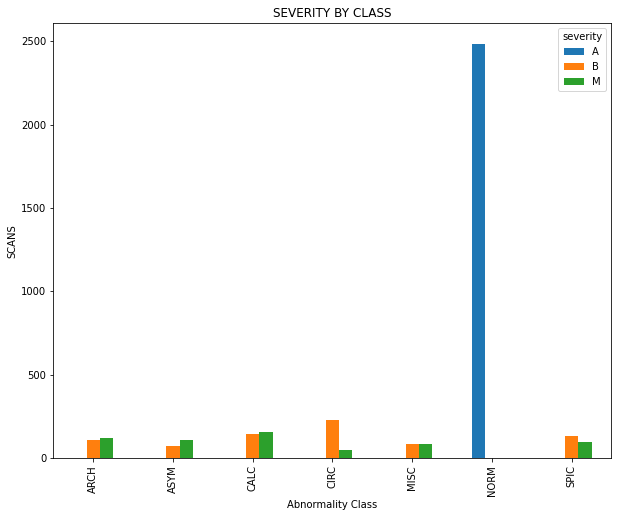

In [53]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar',
                                                               figsize=(10, 8),
                                                               xlabel='Abnormality Class',
                                                               ylabel='SCANS',
                                                               title='SEVERITY BY CLASS');

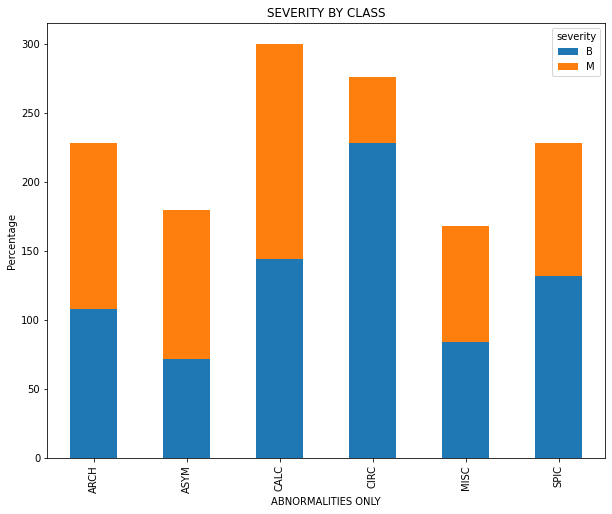

In [54]:
mias[mias.ab_class != 'NORM'].groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar',
                                                                                      stacked=True,
                                                                                      figsize=(10, 8),
                                                                                      xlabel='ABNORMALITIES ONLY',
                                                                                      ylabel='Percentage',
                                                                                      title='SEVERITY BY CLASS');

#### Ejemplo de equilibrio de conjuntos de datos
Calcificaciones antes de equilibrar

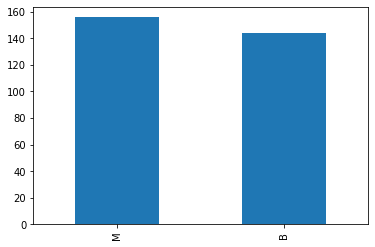

In [55]:
calcifications_unbalanced = mias[mias.ab_class == 'CALC']

calcifications_unbalanced.severity.value_counts().plot(kind='bar');

#### Calcificaciones después de equilibrar

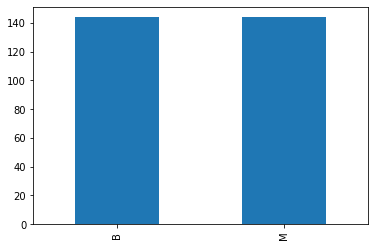

In [56]:
calcifications_balanced = hp.balance_by_severity(mias, 'CALC')

calcifications_balanced.severity.value_counts().plot(kind='bar');

#### Conjunto de datos de resultados finales

In [57]:
final_results = hp.create_final_results_df()

#### MODELO DE ENTRENAMIENTO Y EVALUACIÓN PARA CALCIFICACIONES

In [58]:
calcifications = hp.balance_by_severity(mias, 'CALC')
calcifications

,ab_class,bg,severity,subsample_path,p_matrix
mdb212_0_rotated,CALC,G,B,../subsamples\mdb212_0_rotated.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_0_mirr_lr,CALC,G,B,../subsamples\mdb212_0_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_0_mirr_tp,CALC,G,B,../subsamples\mdb212_0_mirr_tp.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_90_rotated,CALC,G,B,../subsamples\mdb212_90_rotated.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_90_mirr_lr,CALC,G,B,../subsamples\mdb212_90_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
...,...,...,...,...,...
mdb241_180_mirr_lr,CALC,D,M,../subsamples\mdb241_180_mirr_lr.png,"[[77, 81, 84, 84, 88, 90, 94, 101, 104, 104, 1..."
mdb213_0_mirr_tp,CALC,G,M,../subsamples\mdb213_0_mirr_tp.png,"[[127, 130, 135, 143, 153, 159, 161, 157, 156,..."
mdb241_0_rotated,CALC,D,M,../subsamples\mdb241_0_rotated.png,"[[35, 37, 41, 43, 44, 48, 50, 52, 53, 55, 56, ..."
mdb239_0_mirr_tp,CALC,D,M,../subsamples\mdb239_0_mirr_tp.png,"[[210, 211, 211, 210, 208, 207, 208, 211, 212,..."


In [59]:
calcifications = calcifications.sample(len(calcifications), replace=False)

#### Generar datos de prueba y entrenamiento

In [60]:
data_generator = ImageDataGenerator(validation_split=.25,
                                    height_shift_range=.10,
                                    width_shift_range=.10,
                                    rotation_range=30,
                                    rescale=1/255.)

# train data
train_data = data_generator.flow_from_dataframe(calcifications,
                                                x_col="subsample_path",
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)

# test data
test_data = data_generator.flow_from_dataframe(calcifications,
                                               x_col="subsample_path",
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 216 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


#### Crear red neuronal convolucional

In [61]:
cnn_calc = Sequential()
# first layer
cnn_calc.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))

cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))
cnn_calc.add(Dropout(0.25))
# Add dense layer to reduce the number of features
cnn_calc.add(Dense(64, activation='relu'))
cnn_calc.add(Dropout(0.25))
# flattening results
cnn_calc.add(Flatten())
# Dense layer to produce final output
cnn_calc.add(Dense(2, activation='softmax'))
# print summary
cnn_calc.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 64)       

In [62]:
#### Visualiza la Estructura del Modelo

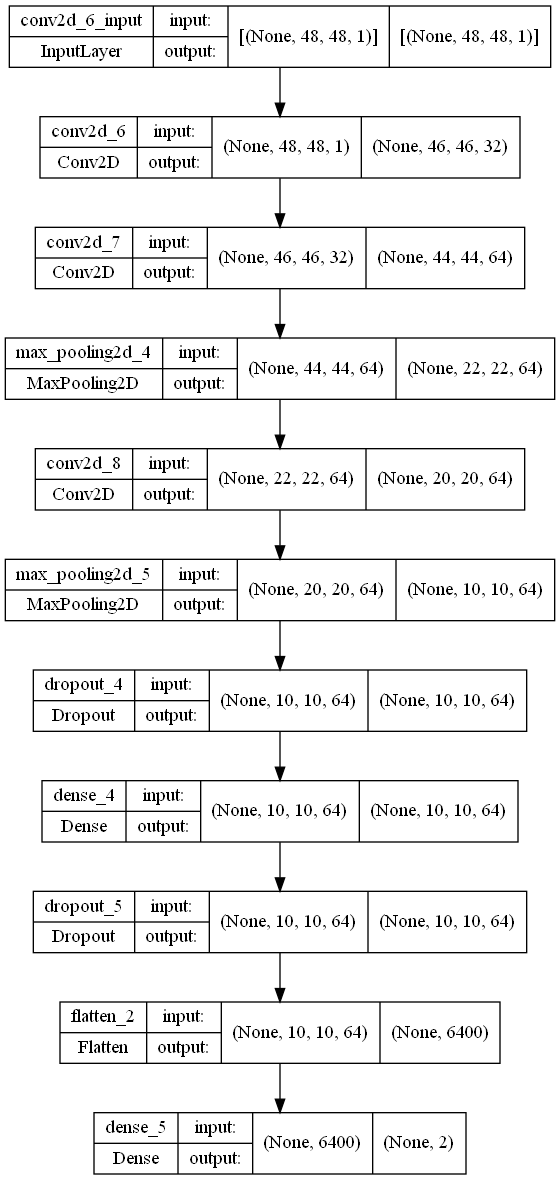

In [63]:
plot_model(cnn_calc, to_file='data_mammo/convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='data_mammo/convnet.png')

In [64]:
# Compilando el modelo
adam = Adam(0.001)
cnn_calc.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [65]:
# Entrenando y evaluando el modelo
# set callbacks
early_stopping = EarlyStopping(patience=3000, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './',
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')

# fit the model
hist = cnn_calc.fit(train_data,
                    validation_data=test_data,
                    epochs=3000,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/3000
7/7 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.4861
Epoch 1: val_loss improved from inf to 0.73899, saving model to .\
INFO:tensorflow:Assets written to: .\assets
7/7 [==============================] - 4s 461ms/step - loss: 0.6996 - accuracy: 0.4861 - val_loss: 0.7390 - val_accuracy: 0.3750
Epoch 2/3000
6/7 [========================>.....] - ETA: 0s - loss: 0.7026 - accuracy: 0.5380
Epoch 2: val_loss improved from 0.73899 to 0.69441, saving model to .\
INFO:tensorflow:Assets written to: .\assets
7/7 [==============================] - 2s 342ms/step - loss: 0.7014 - accuracy: 0.5463 - val_loss: 0.6944 - val_accuracy: 0.3750
Epoch 3/3000
6/7 [========================>.....] - ETA: 0s - loss: 0.6901 - accuracy: 0.5677
Epoch 3: val_loss did not improve from 0.69441
7/7 [==============================] - 1s 81ms/step - loss: 0.6913 - accuracy: 0.5463 - val_loss: 0.7033 - val_accuracy: 0.3750
Epoch 4/3000
7/7 [==============================] - ETA: 0s

In [66]:
# Guardar el modelo
cnn_calc.save('data_mammo/mammo_model.h5')

In [67]:
# Recrea exactamente el mismo modelo solo desde el archivo
cnn_calc = ks.models.load_model('data_mammo/mammo_model.h5')

#### Haciendo predicciones

In [68]:
# predictions
predictions = cnn_calc.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = cnn_calc.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

7/7 [==============================] - 1s 39ms/step - loss: 0.2675 - accuracy: 0.8657
Test loss_value: 0.26750892400741577
Test accuracy: 0.8657407164573669


#### Matriz de confusión

In [69]:
confusion_matrix(expected, predicted)

array([[24,  3],
       [11, 34]], dtype=int64)

#### Reporte de clasificación

In [70]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       0.69      0.89      0.77        27
           1       0.92      0.76      0.83        45

    accuracy                           0.81        72
   macro avg       0.80      0.82      0.80        72
weighted avg       0.83      0.81      0.81        72



#### Resultados

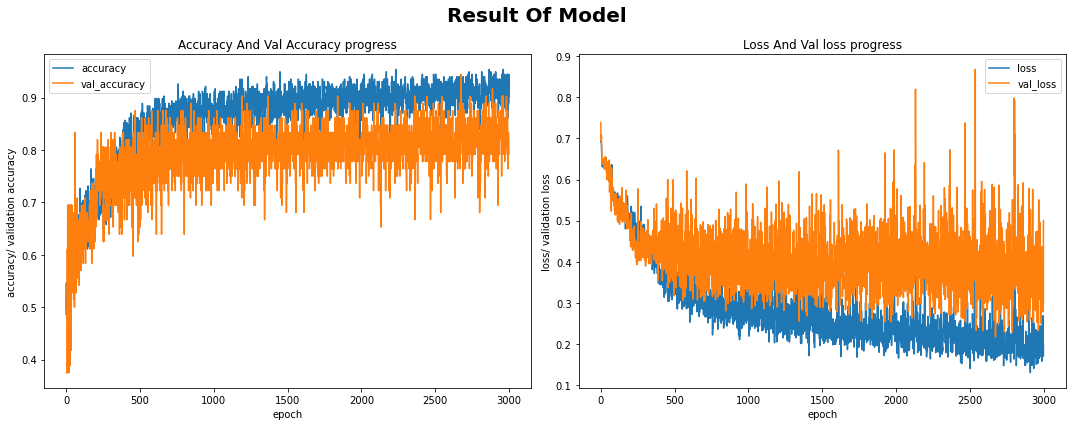

In [71]:
results_plot = hp.plot_results(hist.history['accuracy'],
                            hist.history['val_accuracy'],
                            hist.history['loss'],
                            hist.history['val_loss'])

# enter data to the final results dataframe
results_calc = classification_report(expected, predicted, output_dict=True)

In [72]:
calc_malignant = results_calc['1']
calc_malignant
final_results.loc['calcifications'] = (accuracy,
                                       calc_malignant['precision'],
                                       calc_malignant['recall'],
                                       calc_malignant['f1-score'])
final_results

,test_accuracy,precision,recall,f1-score
calcifications,0.865741,0.918919,0.755556,0.829268


#### Revisando predicciones erroneas

In [73]:
# checking wrong predictions
wrong_predictions = []
images = calcifications.p_matrix
predictions = cnn_calc.predict(test_data)

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [74]:
len(wrong_predictions)

40

In [75]:
a,b,c,d = wrong_predictions[4]

In [76]:
hp.display_probabilities(predictions[4])

0: 56.3998579979%
1: 43.6001449823%


In [77]:
test = calcifications.iloc[a].loc['p_matrix'] == b

In [78]:
np.unique(test)

array([ True])

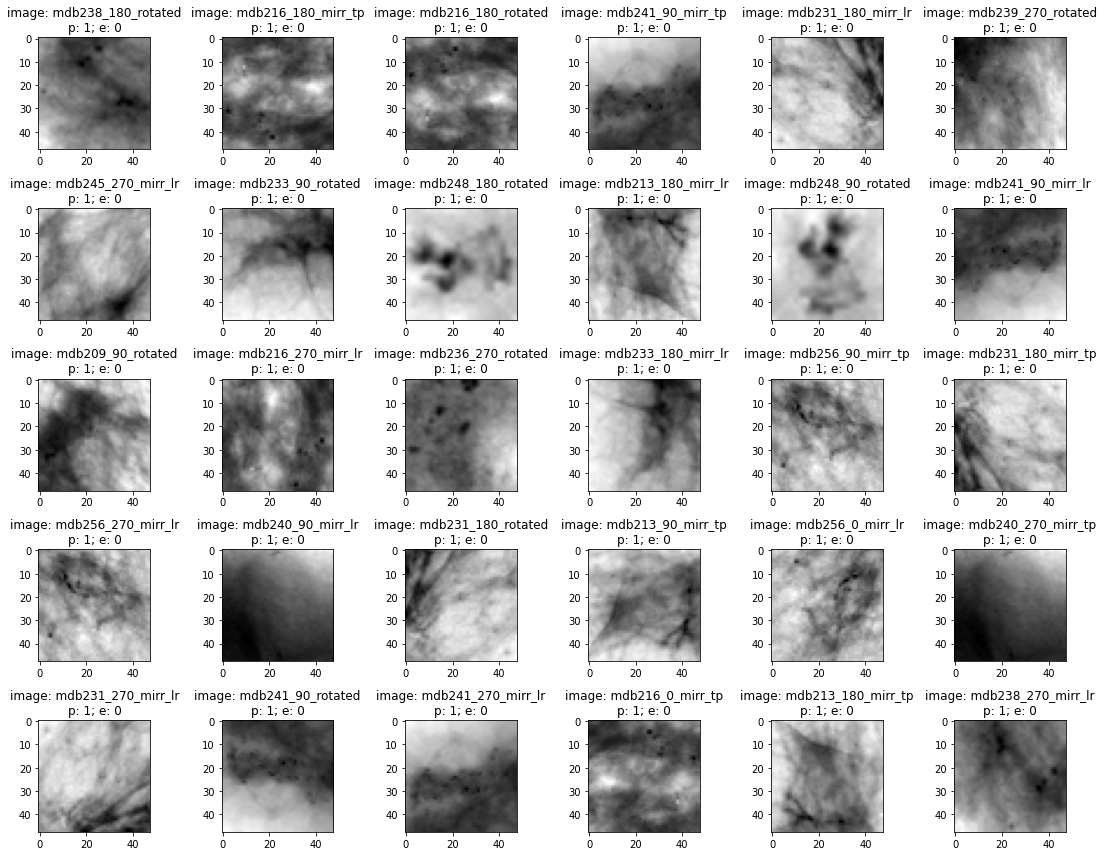

In [79]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {calcifications.iloc[index].name}\np: {predicted}; e: {expected}'
                   )
    plt.tight_layout()

#### MODELO DE ENTRENAMIENTO Y EVALUACIÓN PARA MASAS (FULL BALANCE)

In [80]:
# prepare dataset
circ_balanced = hp.balance_by_severity(mias, 'CIRC')
spic_balanced = hp.balance_by_severity(mias, 'SPIC')
misc_balanced = hp.balance_by_severity(mias, 'MISC')
# shuffle using the length of the smallest sample (CIRC)
circ_balanced = circ_balanced.sample(len(circ_balanced), replace=False)
spic_balanced = spic_balanced.sample(len(circ_balanced), replace=False)
misc_balanced = misc_balanced.sample(len(circ_balanced), replace=False)
# create new dataframe for the masses only
masses_balanced = pd.concat([circ_balanced, spic_balanced])
masses_balanced = pd.concat([masses_balanced, misc_balanced])
# masses dataset
masses_balanced = masses_balanced.sample(len(masses_balanced), replace=False)
masses_balanced

,ab_class,bg,severity,subsample_path,p_matrix
mdb314_270_mirr_lr,MISC,F,B,../subsamples\mdb314_270_mirr_lr.png,"[[163, 171, 179, 183, 183, 183, 182, 178, 179,..."
mdb244_0_mirr_tp,CIRC,D,B,../subsamples\mdb244_0_mirr_tp.png,"[[192, 194, 195, 194, 195, 193, 196, 196, 199,..."
mdb270_0_mirr_tp,CIRC,G,M,../subsamples\mdb270_0_mirr_tp.png,"[[181, 181, 176, 170, 168, 162, 161, 162, 158,..."
mdb188_180_rotated,SPIC,G,B,../subsamples\mdb188_180_rotated.png,"[[190, 190, 192, 195, 191, 193, 194, 190, 188,..."
mdb312_0_rotated,MISC,F,B,../subsamples\mdb312_0_rotated.png,"[[187, 188, 188, 187, 185, 184, 187, 191, 194,..."
...,...,...,...,...,...
mdb175_90_mirr_tp,SPIC,G,B,../subsamples\mdb175_90_mirr_tp.png,"[[149, 148, 148, 144, 143, 144, 148, 152, 152,..."
mdb058_180_mirr_tp,MISC,D,M,../subsamples\mdb058_180_mirr_tp.png,"[[159, 160, 162, 164, 164, 167, 173, 169, 167,..."
mdb028_180_rotated,CIRC,F,M,../subsamples\mdb028_180_rotated.png,"[[135, 131, 130, 129, 128, 127, 127, 128, 129,..."
mdb023_0_rotated,CIRC,G,M,../subsamples\mdb023_0_rotated.png,"[[131, 134, 142, 145, 143, 143, 148, 152, 155,..."


#### Revisando el balanceo de clases

In [81]:
masses_balanced.groupby('ab_class').severity.value_counts()

ab_class  severity
CIRC      B           48
          M           48
MISC      B           49
          M           47
SPIC      M           49
          B           47
Name: severity, dtype: int64

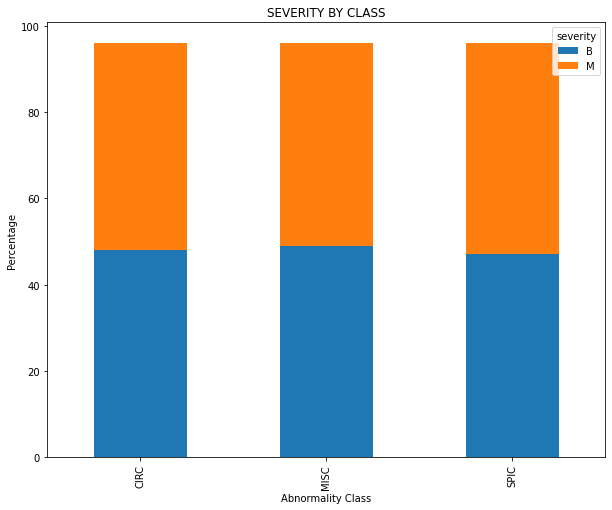

In [82]:
masses_balanced.groupby(['ab_class', 'severity']).severity.size().unstack().plot(kind='bar',
                                                                      stacked=True,
                                                                      figsize=(10, 8),
                                                                      xlabel='Abnormality Class',
                                                                      ylabel='Percentage',
                                                                      title='SEVERITY BY CLASS');

#### Generar datos de prueba y entrenamiento

In [83]:
data_generator = ImageDataGenerator(validation_split=.25,
                                    height_shift_range=.10,
                                    width_shift_range=.10,
                                    rotation_range=30,
                                    rescale=1/255.)

train_data = data_generator.flow_from_dataframe(masses_balanced,
                                                x_col="subsample_path",
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(masses_balanced,
                                               x_col="subsample_path",
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 216 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


#### Crear red neuronal convolucional

In [84]:
mass_cnn = Sequential()
# first layer
mass_cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
mass_cnn.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
mass_cnn.add(MaxPool2D(pool_size=(2, 2)))

mass_cnn.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
mass_cnn.add(MaxPool2D(pool_size=(2, 2)))
mass_cnn.add(Dropout(0.25))
# Add dense layer to reduce the number of features
mass_cnn.add(Dense(64, activation='relu'))
mass_cnn.add(Dropout(0.25))
# flattening results
mass_cnn.add(Flatten())
# Dense layer to produce final output
mass_cnn.add(Dense(2, activation='softmax'))
# print summary
mass_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 10, 10, 64)       

#### Visualizando el modelo

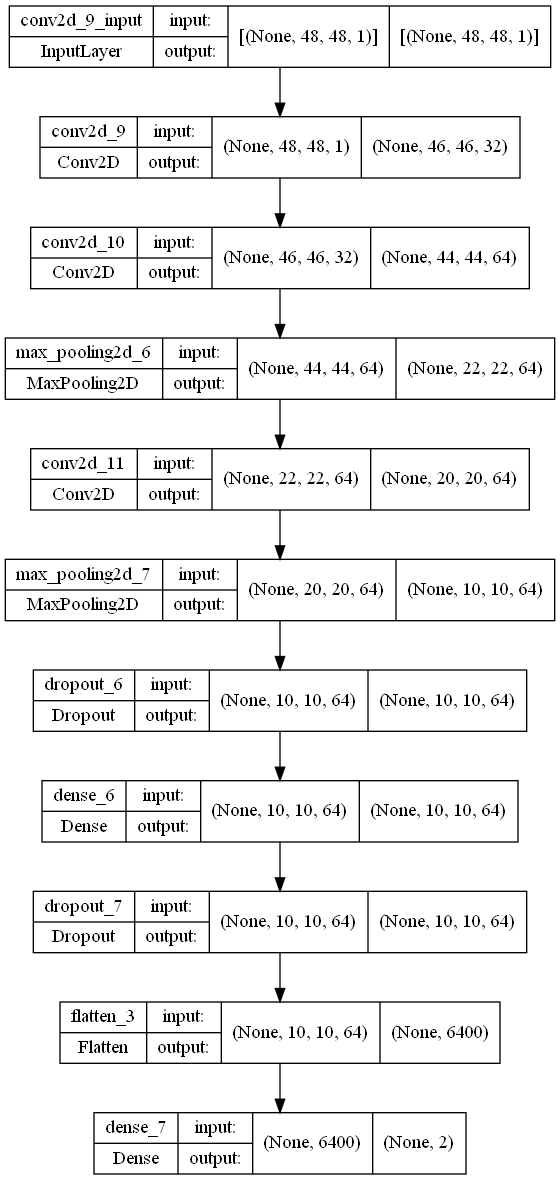

In [85]:
plot_model(mass_cnn, to_file='data_mammo/convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='data_mammo/convnet.png')

#### Compilando el modelo

In [86]:
# # set optmizer and learning rate
adam = Adam(0.001)
mass_cnn.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [87]:
# set callbacks
early_stopping = EarlyStopping(patience=3000, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './',
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')

# fit the model
hist = mass_cnn.fit(train_data,
                    validation_data=test_data,
                    epochs=3000,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/3000
7/7 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.4769
Epoch 1: val_loss improved from inf to 0.69361, saving model to .\
INFO:tensorflow:Assets written to: .\assets
7/7 [==============================] - 4s 505ms/step - loss: 0.6963 - accuracy: 0.4769 - val_loss: 0.6936 - val_accuracy: 0.4722
Epoch 2/3000
7/7 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.4907
Epoch 2: val_loss did not improve from 0.69361
7/7 [==============================] - 1s 88ms/step - loss: 0.6971 - accuracy: 0.4907 - val_loss: 0.6944 - val_accuracy: 0.4722
Epoch 3/3000
6/7 [========================>.....] - ETA: 0s - loss: 0.6947 - accuracy: 0.4891
Epoch 3: val_loss improved from 0.69361 to 0.69294, saving model to .\
INFO:tensorflow:Assets written to: .\assets
7/7 [==============================] - 2s 316ms/step - loss: 0.6949 - accuracy: 0.4815 - val_loss: 0.6929 - val_accuracy: 0.5278
Epoch 4/3000
6/7 [========================>.....] - ETA: 0s

In [88]:
# Guardar el modelo
mass_cnn.save('data_mammo/mammo_model_mass.h5')
# Recrea exactamente el mismo modelo solo desde el archivo
mass_cnn = ks.models.load_model('data_mammo/mammo_model_mass.h5')

#### Haciendo predicciones

In [89]:
# predictions
predictions = mass_cnn.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = mass_cnn.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

7/7 [==============================] - 1s 35ms/step - loss: 0.0362 - accuracy: 0.9907
Test loss_value: 0.03619687631726265
Test accuracy: 0.9907407164573669


In [90]:
confusion_matrix(expected, predicted)

array([[32,  6],
       [ 3, 31]], dtype=int64)

#### Reporte de clasificación

In [91]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       0.91      0.84      0.88        38
           1       0.84      0.91      0.87        34

    accuracy                           0.88        72
   macro avg       0.88      0.88      0.87        72
weighted avg       0.88      0.88      0.88        72



#### Resultados

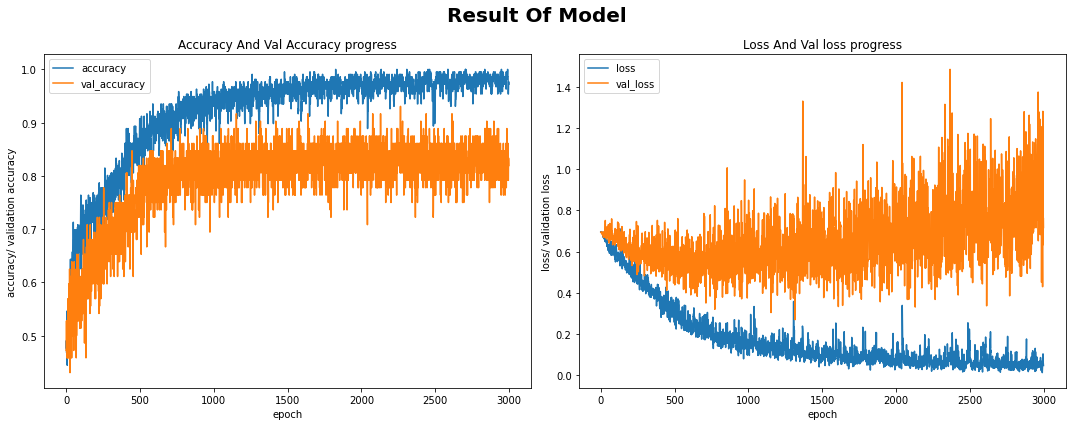

In [92]:
results_plot = hp.plot_results(hist.history['accuracy'],
                               hist.history['val_accuracy'],
                               hist.history['loss'],
                               hist.history['val_loss'])

In [93]:
# enter data to the final results dataframe
results_mass = classification_report(expected, predicted, output_dict=True)
# add entry to the final_results
mass_malignant = results_mass['1']
mass_malignant
final_results.loc['masses_full_bal'] = (accuracy,
                                       mass_malignant['precision'],
                                       mass_malignant['recall'],
                                       mass_malignant['f1-score'])
final_results

,test_accuracy,precision,recall,f1-score
calcifications,0.865741,0.918919,0.755556,0.829268
masses_full_bal,0.990741,0.837838,0.911765,0.873239


#### Resisando predicciones erroneas

In [94]:
# checking wrong predictions
predictions = mass_cnn.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

0: 99.9886751175%
1: 0.0113218397%


In [95]:
images = masses_balanced.p_matrix

In [96]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [97]:
len(wrong_predictions)

36

In [98]:
a,b,c,d = wrong_predictions[15]

In [99]:
hp.display_probabilities(predictions[15])

0: 99.9999761581%
1: 0.0000272593%


In [100]:
test = masses_balanced.iloc[a].loc['p_matrix'] == b

In [101]:
np.unique(test)

array([ True])

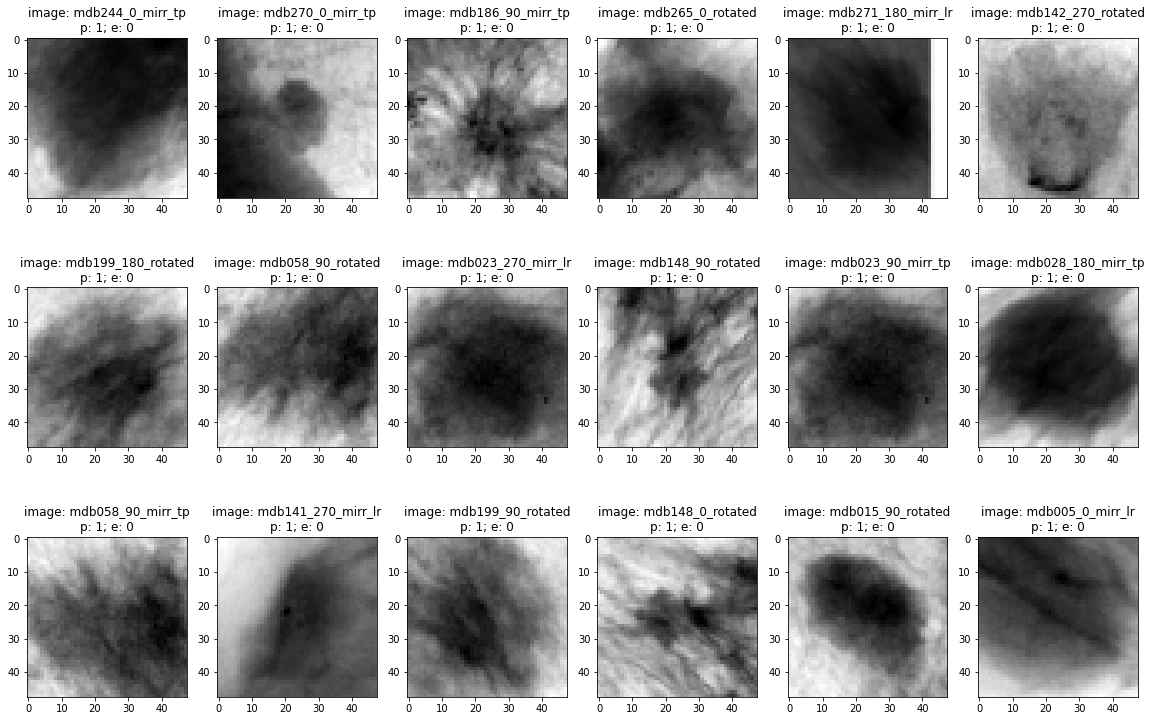

In [102]:
figure, axes = plt.subplots(nrows=3, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {masses_balanced.iloc[index].name}\np: {predicted}; e: {expected}'
                   )
    plt.tight_layout()

<AxesSubplot:>

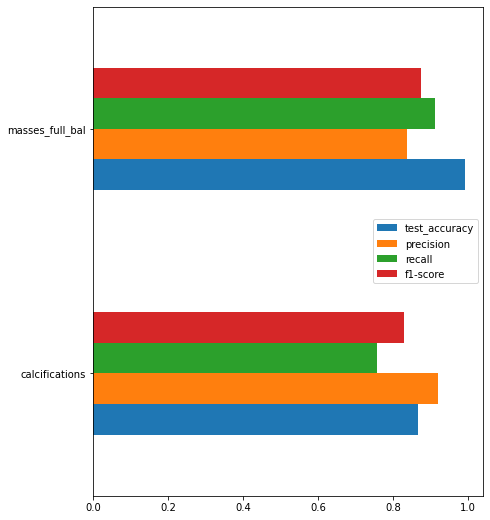

In [103]:
final_results.plot(kind='barh', figsize=(7, 9), legend={'reverse'} )